# Image Scene Classification
## Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Import modules


In [40]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import pathlib
import random
import zipfile

from PIL import Image
from skimage import transform

In [9]:
print(tf.__version__)

2.9.2


## Extract and Explore Data

In [7]:
# Extract the dataset zip file to the base content directory
with zipfile.ZipFile('/content/drive/MyDrive/ImageSceneClassification/dataset.zip', 'r') as zip_ref:
  zip_ref.extractall('/content')

In [13]:
print('Train data:')
for dirpath, dirnames, filenames in os.walk('/content/seg_train'):
  print('There are {} directories and {} files in {}'.format(len(dirnames), len(filenames), dirpath))

print('\nTest data:')
for dirpath, dirnames, filenames in os.walk('/content/seg_test'):
  print('There are {} directories and {} files in {}'.format(len(dirnames), len(filenames), dirpath))

print('\nPrediction data:')
for dirpath, dirnames, filenames in os.walk('/content/seg_pred'):
  print('There are {} directories and {} files in {}'.format(len(dirnames), len(filenames), dirpath))

Train data:
There are 1 directories and 0 files in /content/seg_train
There are 6 directories and 0 files in /content/seg_train/seg_train
There are 0 directories and 2274 files in /content/seg_train/seg_train/sea
There are 0 directories and 2512 files in /content/seg_train/seg_train/mountain
There are 0 directories and 2191 files in /content/seg_train/seg_train/buildings
There are 0 directories and 2382 files in /content/seg_train/seg_train/street
There are 0 directories and 2271 files in /content/seg_train/seg_train/forest
There are 0 directories and 2404 files in /content/seg_train/seg_train/glacier

Test data:
There are 1 directories and 0 files in /content/seg_test
There are 6 directories and 0 files in /content/seg_test/seg_test
There are 0 directories and 510 files in /content/seg_test/seg_test/sea
There are 0 directories and 525 files in /content/seg_test/seg_test/mountain
There are 0 directories and 437 files in /content/seg_test/seg_test/buildings
There are 0 directories and 5

In [20]:
def view_random_image(dir, label):
  # Construct a target folder path
  folder = os.path.join(dir, label)

  # Randomly sample a single image
  random_image = random.sample(os.listdir(folder), 1)

  # Read and show the sampled image
  img = mpimg.imread(os.path.join(folder, random_image[0]))
  plt.imshow(img)
  plt.title(label)
  plt.axis('off')

  return img

Image shape: (150, 150, 3)


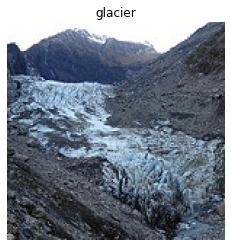

In [15]:
img = view_random_image('/content/seg_train/seg_train/', 'glacier')

In [19]:
# Get all class names from the directory structure
train_dir = pathlib.Path('/content/seg_train/seg_train/')
class_names = np.array(sorted([item.name for item in train_dir.glob('*')]))

print(class_names)

['buildings' 'forest' 'glacier' 'mountain' 'sea' 'street']


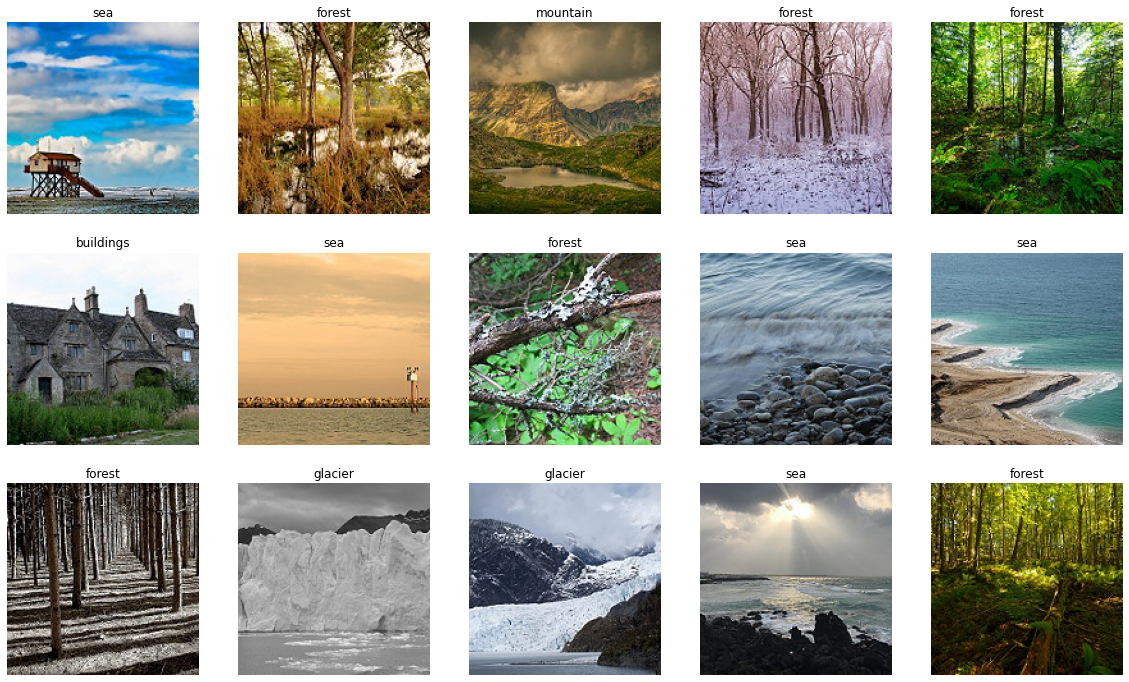

In [30]:
plt.figure(figsize=(20, 12))
for i in range(15):
  plt.subplot(3, 5, i+1)
  class_name = random.choice(class_names)
  img = view_random_image(str(train_dir), class_name)

## Prepare Data for the Model

In [32]:
train_dir = '/content/seg_train/seg_train/'
test_dir = '/content/seg_test/seg_test/'

# Create augmented data generator instances
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.,
                                                                rotation_range=0.2,
                                                                width_shift_range=0.2,
                                                                height_shift_range=0.2,
                                                                zoom_range=0.2,
                                                                horizontal_flip=True)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.)

# Load data (data, labels) from the train and test directories
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(150, 150),
                                               batch_size=32,
                                               class_mode='categorical')

test_data = test_datagen.flow_from_directory(test_dir,
                                            target_size=(150, 150),
                                            batch_size=32,
                                            class_mode='categorical')

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


## Build and Train a CNN Classifier

In [34]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(150, 150, 3)))
model.add(tf.keras.layers.MaxPool2D())
model.add(tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPool2D())
model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPool2D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(len(class_names), activation='softmax'))

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 18, 18, 64)       0

In [39]:
history = model.fit(train_data,
                    epochs=4,
                    batch_size=32,
                    steps_per_epoch=len(train_data),
                    validation_data=test_data,
                    validation_steps=len(test_data))

Epoch 1/4
439/439 [==============================] - 475s 1s/step - loss: 1.0160 - accuracy: 0.6035 - val_loss: 0.7464 - val_accuracy: 0.7230
Epoch 2/4
439/439 [==============================] - 474s 1s/step - loss: 0.7811 - accuracy: 0.7059 - val_loss: 0.6286 - val_accuracy: 0.7650
Epoch 3/4
439/439 [==============================] - 429s 977ms/step - loss: 0.6816 - accuracy: 0.7457 - val_loss: 0.6582 - val_accuracy: 0.7520
Epoch 4/4
439/439 [==============================] - 408s 930ms/step - loss: 0.6009 - accuracy: 0.7789 - val_loss: 0.5062 - val_accuracy: 0.8193


## Evaluate the model


In [41]:
model.evaluate(test_data)

94/94 [==============================] - 22s 233ms/step - loss: 0.5062 - accuracy: 0.8193


[0.5061990022659302, 0.8193333148956299]

Text(0, 0.5, 'Loss')

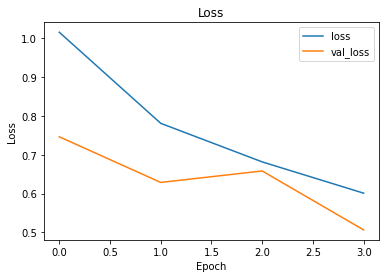

In [43]:
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'Accuracy')

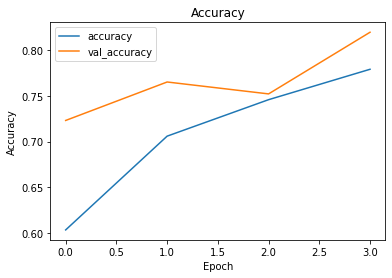

In [44]:
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

## Save and Load the Model

In [46]:
model.save('/content/drive/MyDrive/ImageSceneClassification/models', save_format='tf')

In [47]:
model_loaded = tf.keras.models.load_model('/content/drive/MyDrive/ImageSceneClassification/models')

In [48]:
model_loaded.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 18, 18, 64)       0

In [49]:
def process(filename):
  image = Image.open(filename)
  image = np.array(image).astype('float32')
  image = transform.resize(image, (150, 150, 3))
  image = np.expand_dims(image, axis=0)
  return image

In [50]:
pred_label = model_loaded.predict(process('/content/seg_pred/seg_pred/10005.jpg'))
print(pred_label)
print(class_names[np.argmax(pred_label)])

1/1 [==============================] - 0s 144ms/step
[[0. 0. 0. 1. 0. 0.]]
mountain


In [60]:
!zip -r '/content/drive/MyDrive/ImageSceneClassification/models.zip' '/content/drive/MyDrive/ImageSceneClassification/models/'

  adding: content/drive/MyDrive/ImageSceneClassification/models/ (stored 0%)
  adding: content/drive/MyDrive/ImageSceneClassification/models/variables/ (stored 0%)
  adding: content/drive/MyDrive/ImageSceneClassification/models/variables/variables.data-00000-of-00001 (deflated 12%)
  adding: content/drive/MyDrive/ImageSceneClassification/models/variables/variables.index (deflated 66%)
  adding: content/drive/MyDrive/ImageSceneClassification/models/assets/ (stored 0%)
  adding: content/drive/MyDrive/ImageSceneClassification/models/saved_model.pb (deflated 89%)
  adding: content/drive/MyDrive/ImageSceneClassification/models/keras_metadata.pb (deflated 91%)
